In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper, psiam_tied_data_gen_wrapper_V2
import sys
import multiprocessing
from psiam_tied_dv_map_utils import cum_A_t_fn, cum_E_t_fn

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [5]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]

In [6]:
# Remove rows where timed_fix, intended_fix, or response_poke is NaN
df_1 = df_1.dropna(subset=['timed_fix', 'intended_fix', 'response_poke'])

In [7]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [8]:
vp_sample = vp.sample(int(1e6))[0]

In [9]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor
# t_A_aff = 0.05 # NOTE: TEMP, to test if negative afferent delay is causing VBMC to not converge

In [10]:
t_A_aff

-0.22651056795239266

# VBMC

## loglike fn

In [11]:
T_trunc = 0.21
T_large = 1

In [12]:
def cdf_pro_tied(t, V_A, theta_A, t_A_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, K_max):
    cum_proactive = cum_A_t_fn(t - t_A_aff, V_A, theta_A)
    cum_reactive = cum_E_t_fn(t - t_E_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    return cum_proactive + cum_reactive - cum_proactive * cum_reactive


In [13]:
def compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']

    rt = timed_fix
    t_stim = intended_fix
    
    K_max = 10

    
    if rt - t_stim < T_trunc or rt - t_stim > T_large:
        likelihood = 0
    else:
        t_motor = 0
        if choice == 3:
            likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, \
                                        theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]
        elif choice == 2:
            likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,\
                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]


    c1 = cdf_pro_tied(t_stim + T_trunc, V_A, theta_A, t_A_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, K_max)
    c2 = cdf_pro_tied(t_stim + T_large, V_A, theta_A, t_A_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, K_max)
    trunc_factor = c2 - c1
    if trunc_factor <= 0:
        trunc_factor = 1e-60
    likelihood /= trunc_factor



    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params


    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L)\
                                       for _, row in df_1.iterrows())

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [14]:
# rate_lambda_bounds = [0.01, 0.2]
# theta_E_bounds = [30, 60]
# T_0_bounds = [0.1*(1e-3), 1*(1e-3)]


# t_E_aff_bounds = [0.001, 0.1]
# Z_E_bounds = [-10, 10]
# L_bounds = [0.1, 1.99]


rate_lambda_bounds = [0.04, 0.1]
T_0_bounds = [0.20*(1e-3), 0.30*(1e-3)]
theta_E_bounds = [45, 65]

t_E_aff_bounds = [0.01, 0.05]
Z_E_bounds = [-5, 5]
L_bounds = [0.1, 0.9]
# ---
# rate_lambda_plausible_bounds =  [0.05, 0.09]
# T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
# theta_E_plausible_bounds = [40, 55]

# t_E_aff_plausible_bounds = [0.01, 0.05]
# Z_E_plausible_bounds = [-5, 5]
# L_plausible_bounds = [0.5, 1.5]

rate_lambda_plausible_bounds =  [0.07, 0.09]
T_0_plausible_bounds = [0.22*(1e-3), 0.29*(1e-3)]
theta_E_plausible_bounds = [50, 60]

t_E_aff_plausible_bounds = [0.015, 0.03]
Z_E_plausible_bounds = [-2, 2]
L_plausible_bounds = [0.5, 0.8]


## prior

In [15]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + L_logpdf


## prior + loglike

In [16]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [17]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_E_aff_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                t_E_aff_bounds[1], Z_E_bounds[1], L_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                t_E_aff_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                t_E_aff_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10    -3347685.82      8938.67          inf        2        inf     start warm-up
     1         15    -3323461.90     19171.35    477744.47        2        inf     
     2         20    -3328696.35     10325.72   1088612.02        2   1.49e+07     
     3         25    -3290063.19     10106.38    119489.56        2   1.79e+06     
     4         30    -3306829.04      7830.80      4267.53        2    1.4e+05     
     5         35    -3309010.30     13103.97     99035.81        2    1.4e+06     
     6         40    -3273119.60      9898.19   1093278.25        2    1.5e+07     
     7         45    -3239163.61      1577.2

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/gaussian_process_train.py:692: RuntimeWarning: divide by zero encountered in log
  np.log(


    55        285    -3221836.99         5.65       460.24       13    6.3e+03     
    56        290    -3221831.62         5.88         0.00       13       37.5     
    57        295    -3221835.95         6.11         0.00       13       34.8     
    58        300    -3221835.68         6.26         0.00       13       21.8     
    59        305    -3221869.64        11.33       243.34       13   3.46e+03     
    60        310    -3221869.29        11.83         0.15       13       42.6     
    61        315    -3221866.52        11.94         0.00       13         49     
    62        320    -3221880.70        12.33         0.00       13       88.3     
    63        325    -3221887.23        16.99         0.42       13       84.1     
    64        330    -3221897.42        15.29         0.00       13       84.9     
    65        335    -3221929.39        15.09         0.00       13        157     
    66        340    -3221922.39        15.02         0.00       13       73

In [ ]:
vbmc.save('NOT_working_ONLY_TIED_params_led_off_data_RIGHT_CENSOR.pkl', overwrite=True)

In [ ]:
with open('NOT_working_ONLY_TIED_params_led_off_data_LEFT_CENSOR.pkl', 'rb') as f:
    vp = pickle.load(f)

In [ ]:
vp = vp.vp

## corner plots

Too few points to create valid contours
Too few points to create valid contours


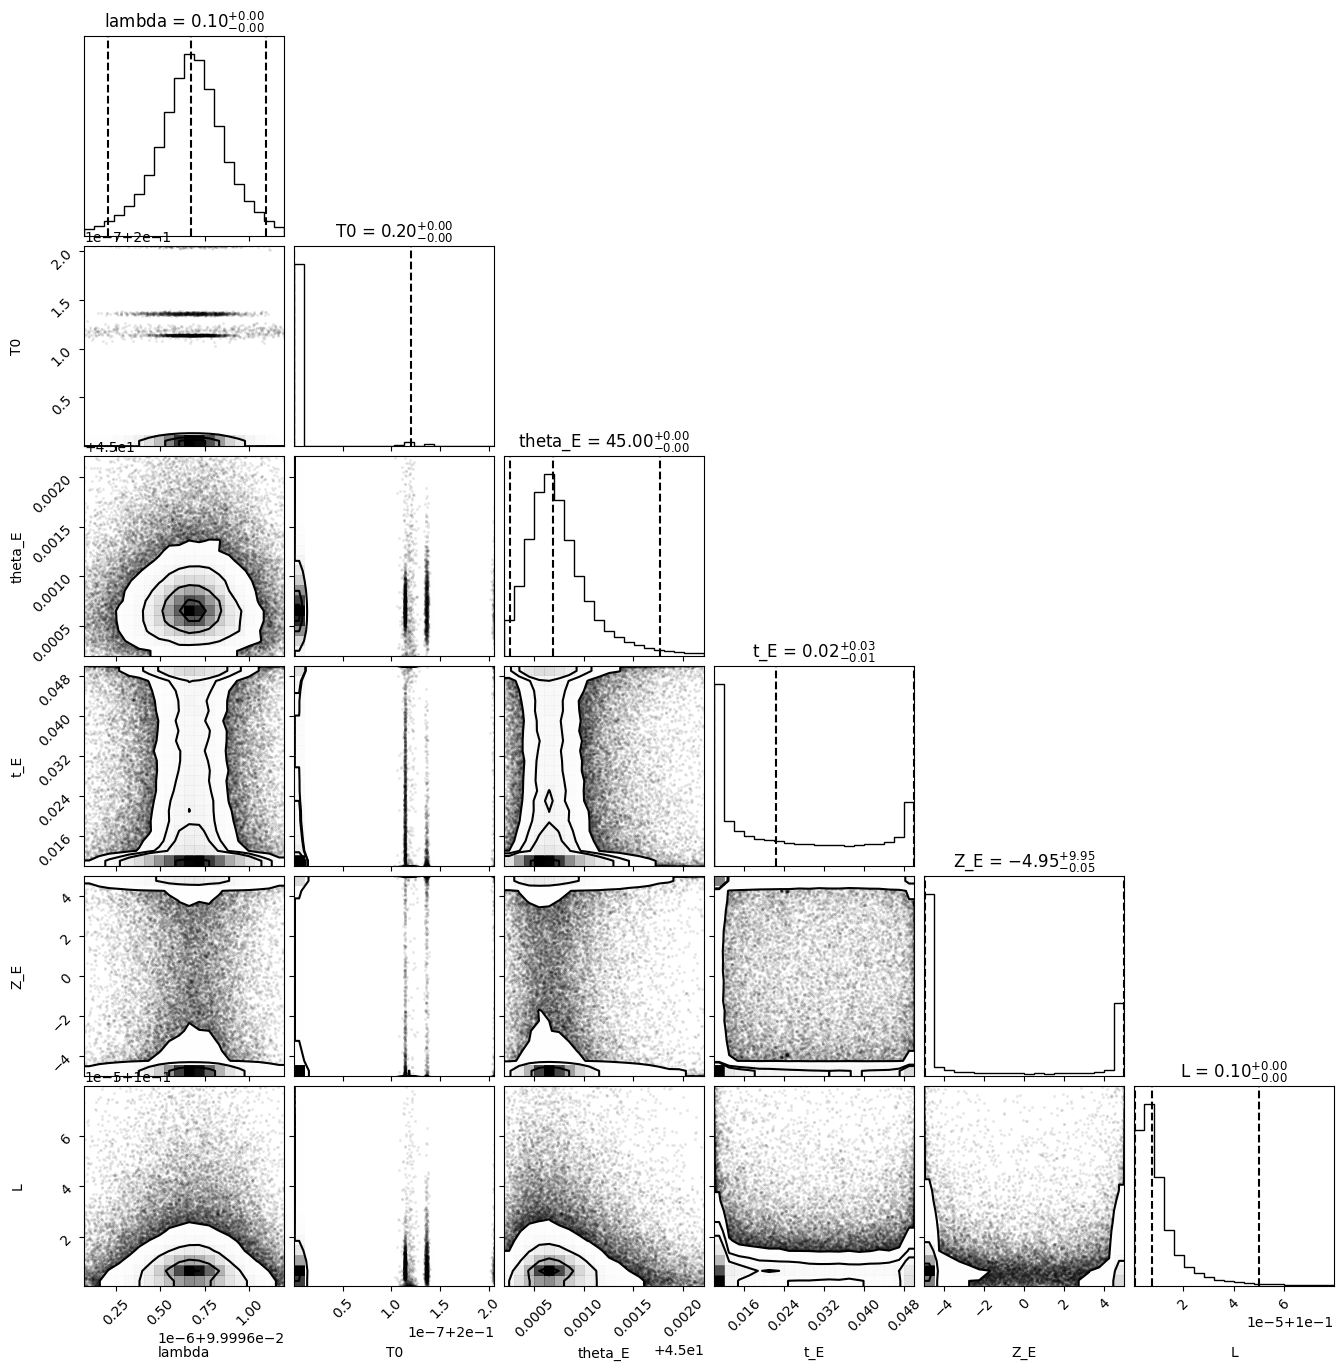

In [18]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

param_labels = ['lambda', 'T0', 'theta_E', 't_E', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [1, 99], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# diagnose

## simulate data

In [19]:
lambda_mean = np.mean(vp_samples[:,0])
T0_mean = np.mean(vp_samples[:,1]) / 1e3
theta_E_mean = np.mean(vp_samples[:,2])

t_E_aff_mean = np.mean(vp_samples[:,3])
Z_E_mean = np.mean(vp_samples[:,4])
L_mean = np.mean(vp_samples[:,5])

In [20]:
iter_num = 2
N_print = 3
dt = 1e-3
N_sim = int(500e3)

# sample intended_fix of N_sim from df_1
t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)

# sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
#                                 t_stim_0, t_stim_tau, iter_num, N_print, dt) for iter_num in range(N_sim))
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

# design diagnostics

In [30]:
class Diagnostics:
    """
    Remove truncated aborts by urself

    data frame with column names
    rt: RT wrt fixation
    t_stim: stimulus onset
    choice: 1 or -1
    ABL, ILD
    correct: 1 or 0
    """
    def __init__(self, data):
        self.data = data

    def plot_rtd_wrt_fix(self,bins):
        """
        return x and y for plotting
        """
        df = self.data.copy()
        rt_wrt_fix = df['rt']
        rt_wrt_fix_hist, _ = np.histogram(rt_wrt_fix, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_fix_hist
    

    def plot_rtd_wrt_stim(self,bins):
        df = self.data.copy()
        rt_wrt_stim = df['rt'] - df['t_stim']
        rt_wrt_stim_hist, _ = np.histogram(rt_wrt_stim, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_stim_hist

    def plot_tacho(self, bins):
        # prob of correct vs RT
        df = self.data.copy()
        df['RT_bin'] = pd.cut(df['rt'] - df['t_stim'], bins=bins, include_lowest=True)
        grouped_by_rt_bin = df.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
        grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
        return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']
    
    def plot_chrono(self):
        # mean rt vs abs ILD for each ABL
        df = self.data.copy()
        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        abl_rt_dict = {}

        for ABL in all_ABL:
            per_ILD_rt = np.zeros_like(all_ILD)
            for idx, ILD in enumerate(all_ILD):
                filtered_df = df[ (df['ABL'] == ABL) \
                                            & (df['ILD'].isin([ILD, -ILD])) ]
                mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
                per_ILD_rt[idx] = mean_rt
            abl_rt_dict[ABL] = per_ILD_rt
        
        return all_ILD, abl_rt_dict

    def plot_quantile(self):
        # 10 - 90 percentiles in steps of 20
        df = self.data.copy()
        df['rt_wrt_stim'] = df['rt'] - df['t_stim']

        abl_ild_quantiles = {}
        quantile_levels = [0.1, 0.3, 0.5, 0.7, 0.9]

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        for abl in all_ABL:
            abl_ild_quantiles[abl] = {}
            for ild in all_ILD:
                filtered_df = df[(df['ABL'] == abl) & (df['ILD'].isin([ild, -ild]))]
                quantiles = filtered_df['rt_wrt_stim'].replace([np.nan, np.inf, -np.inf], np.nan).dropna().quantile(quantile_levels).tolist()
                abl_ild_quantiles[abl][ild] = quantiles

        return abl_ild_quantiles
    
    def plot_psycho(self):
        df = self.data.copy()
        prob_choice_dict = {}

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())

        for abl in all_ABL:
            filtered_df = df[df['ABL'] == abl]
            # prob_choice_dict[abl] = [sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]
            prob_choice_dict[abl] = [np.nan if len(filtered_df[filtered_df['ILD'] == ild]) == 0 else sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]

        return prob_choice_dict



In [31]:
T_trunc_left_aborts = 0.3
T_trunc_left_stim = 0.21

In [32]:
### Add choice ###
df['correct'] = ((df['ILD'] * (2*df['response_poke'] - 5)) > 0).astype(int)
df['choice'] = 2*df['response_poke'] - 5

In [33]:
# sim
# remove trunc aborts
sim_results_1 = [res for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < T_trunc_left_aborts)]
# remove right trunc valid trials
sim_results_2 = [res for res in sim_results_1 if res['rt'] - res['t_stim'] > T_trunc_left_stim]
for d in sim_results_2:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

# all trials df
sim_results_pd_valid = pd.DataFrame(sim_results_2)
# only valid trials df
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj = Diagnostics(sim_results_pd_valid)
sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)

# data
df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']

# remove trunc aborts
df_led_off_trunc = df_led_off[ ~( (df_led_off['rt'] < df_led_off['t_stim']) & (df_led_off['rt'] < T_trunc_left_aborts)  ) ]
# right trunc
df_led_off_trunc_1 =  df_led_off_trunc[df_led_off_trunc['rt'] - df_led_off_trunc['t_stim'] > T_trunc_left_stim]
# only valid
df_led_off_trunc_1_valid = df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']]

data_diagnose_obj = Diagnostics(df_led_off_trunc_1)
data_diagnose_obj_valid = Diagnostics(df_led_off_trunc_1_valid)

In [34]:
sim_results_pd_valid_1[sim_results_pd_valid_1['ABL'] == 60]['ILD'].unique()

array([-1.,  4.,  2.,  1., -2., -4., -8.,  8.])

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


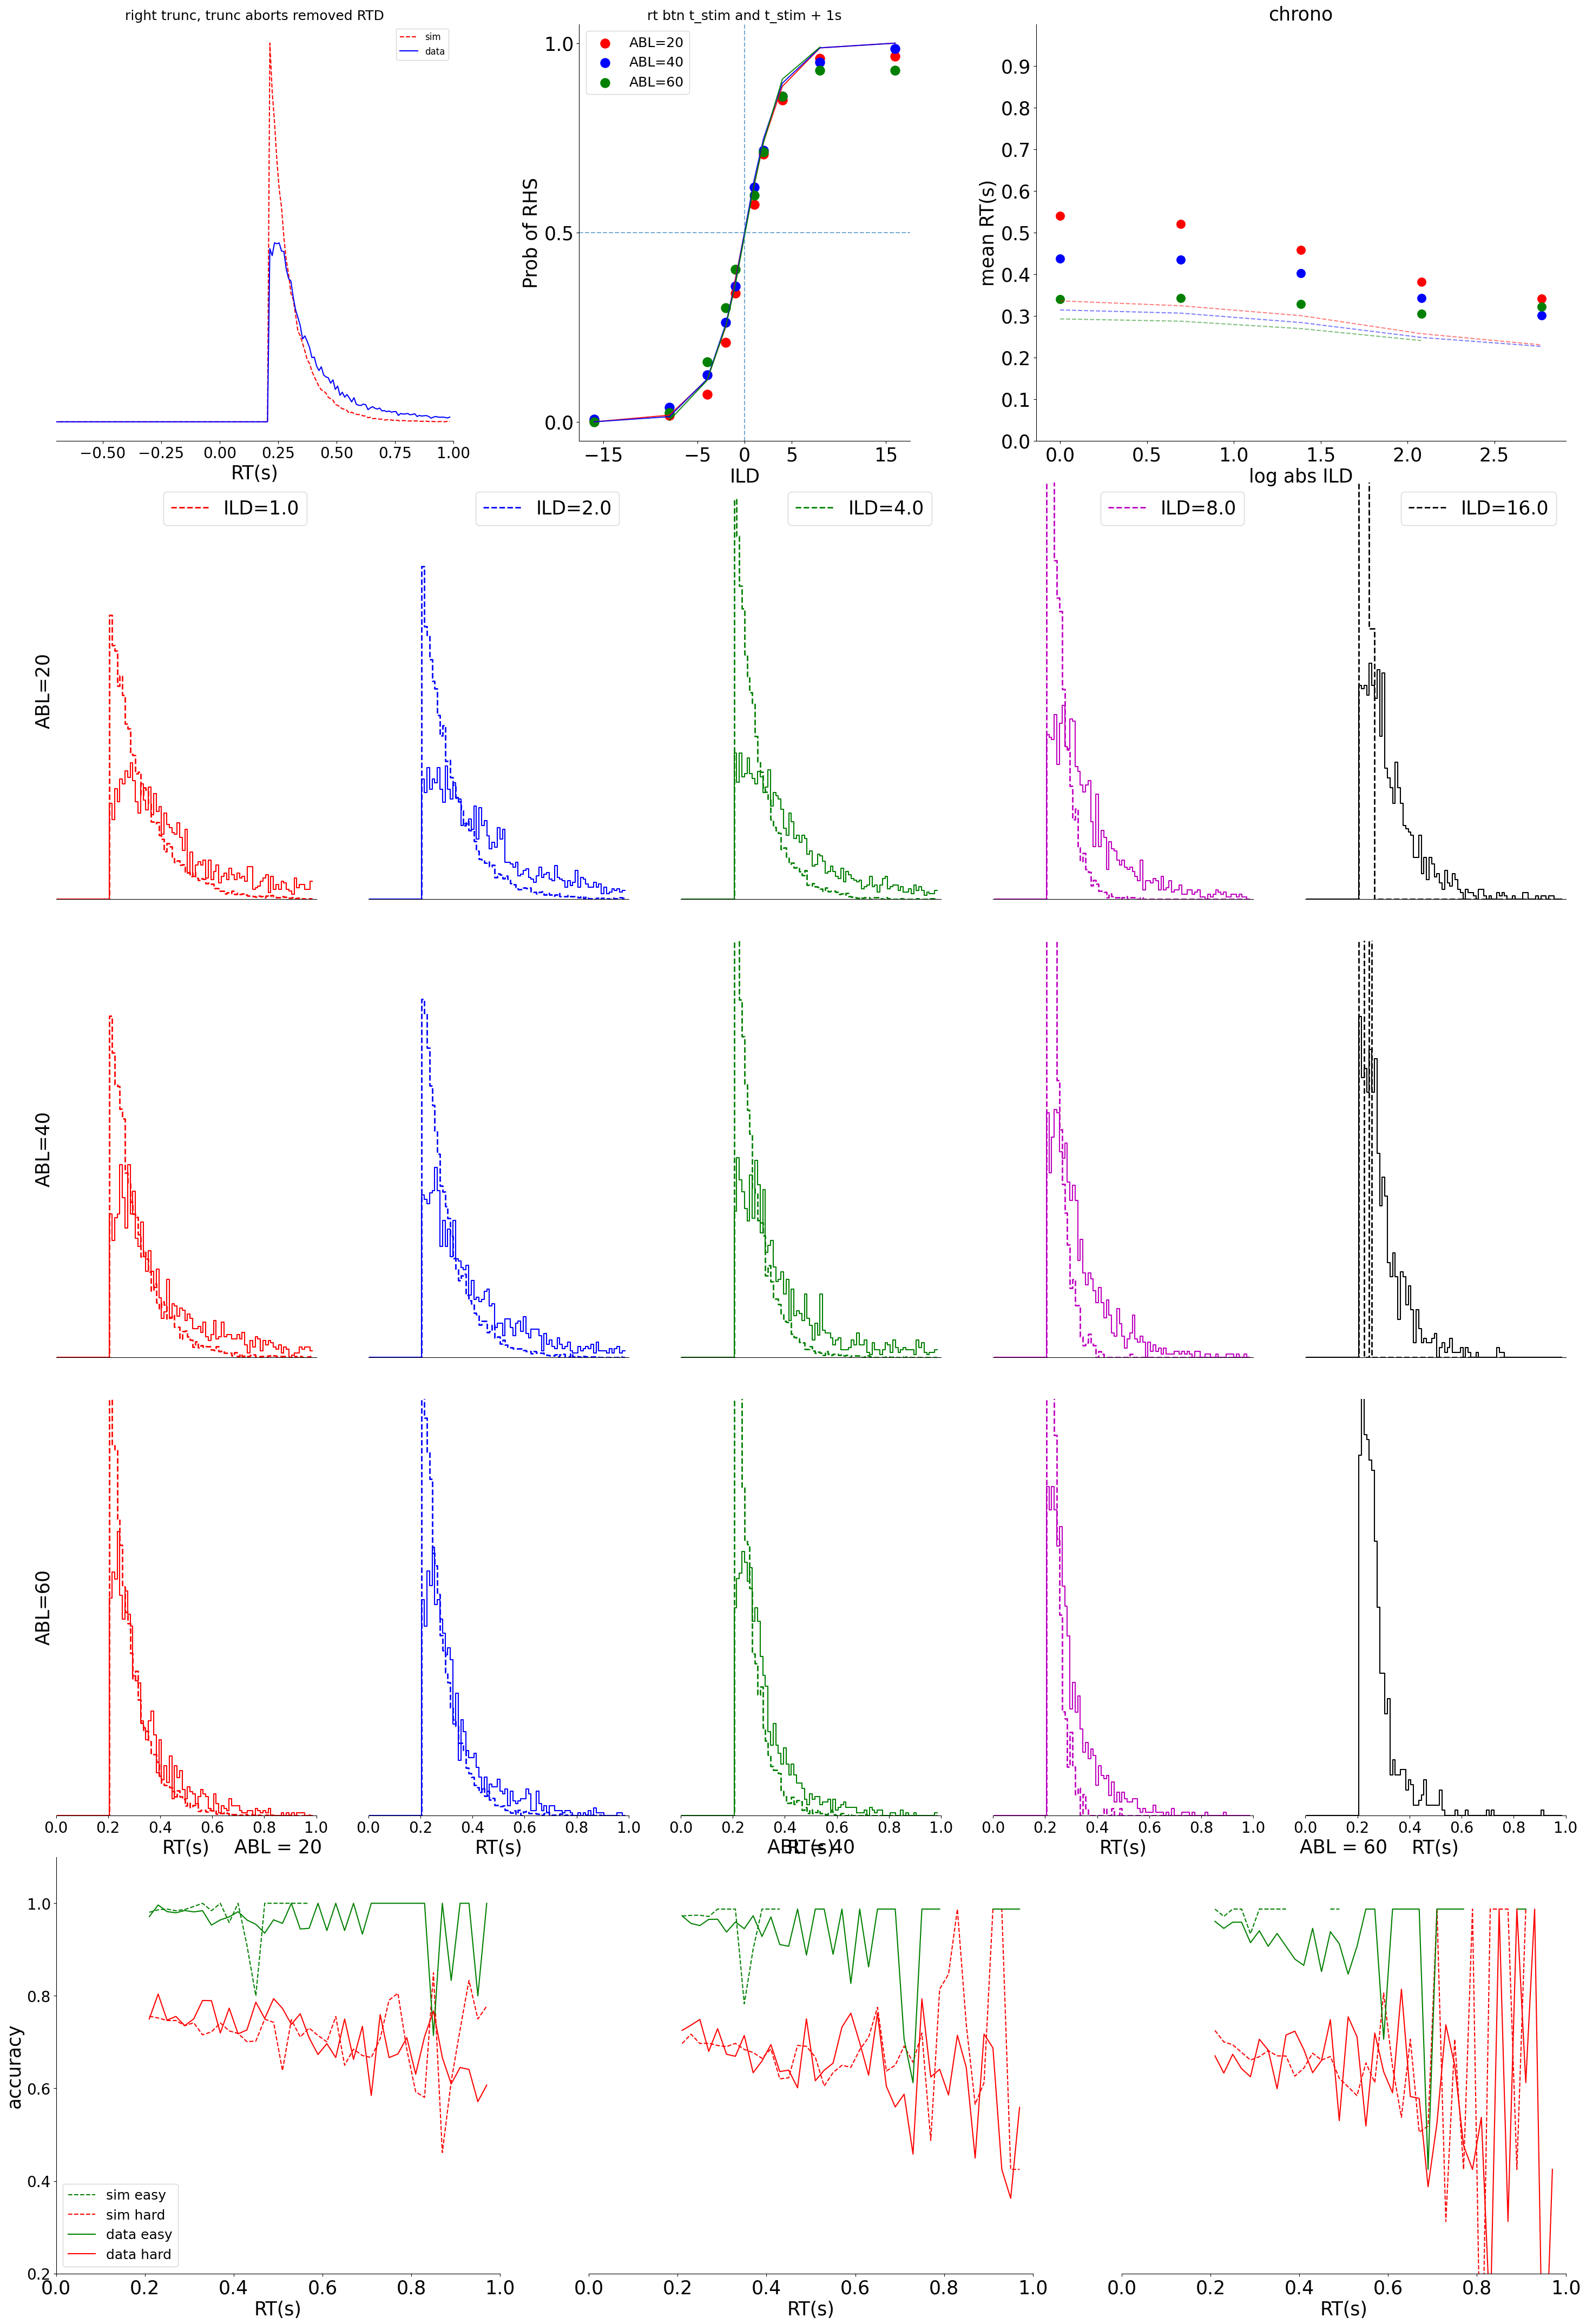

In [35]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 1)

# 1 - psycho 
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax_chrono.plot(np.log(x), sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax_chrono.scatter(np.log(x), data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 1)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 1, 0.1))

# RTDs per ABL
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='sim', linewidth=2)

        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
        ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color=ILD_colors[ILD])

        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = df_led_off_trunc_1_valid[ (df_led_off_trunc_1_valid['ABL'] == ABL) & (df_led_off_trunc_1_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 1)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)



## valid rt wrt stim

In [ ]:
plt.figure(figsize=(15,10))
rt_wrt_stim = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > res['t_stim']]
bins = np.arange(0, 1, 0.005)
plt.hist(rt_wrt_stim, bins=bins, density=True, histtype='step', label='vp params');

data_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']
plt.hist(data_rt_wrt_stim, bins=bins, density=True, histtype='step', color='red', label='data');
plt.xlabel('RT - Stimulus (s)');    
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt stim')
# plt.xlim(-1,1)
plt.grid(True)
plt.xlim(0,0.4)
xticks = np.arange(0, 0.4, 0.01)
plt.xticks(xticks, [f'{x:.2f}' for x in xticks]);

## valid rt wrt fix

In [ ]:
rt = [res['rt'] for res in sim_results if res['rt'] > res['t_stim']]
data_rt = df_1['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(data_rt, bins=bins, density=True, histtype='step', color='red', label='data');

plt.xlabel('RT (s) wrt fix');
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt fix')


## all rt wrt fix

In [ ]:
all_rt = [res['rt'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt inclding aborts wrt fix')

# all rt wrt fix, trunc aborts removed

In [ ]:
all_rt = [res['rt'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt fix');

## all rt wrt stim

In [ ]:
# all_rt = [res['rt'] - res['t_stim'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-2, 2, 0.01)
# plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data', ls='--');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt wrt stim');

In [ ]:
(df_led_off_all_rt > 1).sum() / len(df_led_off_all_rt)

# all rt wrt stim trunc aborts removed

In [ ]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt stim');

## psychometric

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ]
sim_results_valid_df = sim_results_valid_df.copy()

sim_results_valid_df.loc[:, 'RHS'] = (sim_results_valid_df['choice'] > 0).astype(int)
sim_grouped = sim_results_valid_df.groupby('ILD')['RHS'].mean().reset_index()

# data
data_df = df_1.copy()
data_df.loc[:, 'RHS'] = (data_df['response_poke'] == 3).astype(int)
data_grouped = data_df.groupby('ILD')['RHS'].mean().reset_index()

plt.plot(data_grouped['ILD'], data_grouped['RHS'], label='data', marker='o', color='red');
plt.plot(sim_grouped['ILD'], sim_grouped['RHS'], label='vp params', marker='o');
plt.xlabel('ILD (dB)');
plt.ylabel('P(RHS)');
plt.legend();

## tachometric

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

# sim results
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ].copy()
sim_results_valid_df.loc[:, 'correct'] = (sim_results_valid_df['choice'] * sim_results_valid_df['ILD'] > 0)
sim_results_valid_df.loc[:, 'rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

sim_results_valid_df['rt_bin'] = pd.cut(sim_results_valid_df['rt_wrt_stim'], bins=bins, right=False)
sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, sim_grouped['correct'], linestyle='-', label='sim', color='b')

# data
data_df = df_1.copy()
data_df.loc[:, 'correct'] = ((2*data_df['response_poke'] - 5) * data_df['ILD'] > 0).astype(int)
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']

data_df['rt_bin'] = pd.cut(data_df['rt_wrt_stim'], bins=bins, right=False)
data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, data_grouped['correct'], linestyle='-', label=' data', color='r')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('P(Correct)');
plt.legend();


# tachometric ABL wise

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

plt.figure(figsize=(20, 5))

ABL_values = np.sort(df_1['ABL'].unique())
colors = ['b', 'g', 'r']  # You can pick your own color scheme
a = 1
for abl_val, c in zip(ABL_values, colors):
    plt.subplot(1, len(ABL_values), a)
    # --- 1) Filter SIM dataframe for the given ABL value ---
    sim_sub = sim_results_valid_df[sim_results_valid_df['ABL'] == abl_val].copy()
    # Bin the RT values
    sim_sub['rt_bin'] = pd.cut(sim_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    sim_grouped = sim_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot SIM result (solid line)
    plt.plot(bin_centers, sim_grouped['correct'], 
            linestyle='-', 
            color=c, 
            label=f'Sim ABL={abl_val}')
    
    # --- 2) Filter DATA dataframe for the given ABL value ---
    data_sub = data_df[data_df['ABL'] == abl_val].copy()
    # Bin the RT values
    data_sub['rt_bin'] = pd.cut(data_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    data_grouped = data_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot DATA result (dashed line)
    plt.plot(bin_centers, data_grouped['correct'], 
            linestyle='--', 
            color=c, 
            label=f'Data ABL={abl_val}')

        # Cosmetics
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('P(Correct)')
    plt.ylim([0.3, 1])  # If you want to fix y-limits
    plt.xlim(0, 0.5)
    plt.legend()
    a += 1



# investigate second bump

In [ ]:
low_rt = 0.21
high_rt = 0.33

# data
data_df = df_1.copy()
data_df.loc[:, 'correct'] = ((2*data_df['response_poke'] - 5) * data_df['ILD'] > 0).astype(int)
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


counts = df_second_bump["ABL"].value_counts() / len(df_second_bump)
counts_all = data_df["ABL"].value_counts() / len(data_df)
combined = pd.DataFrame({
    'Second Bump': counts,
    'All Data': counts_all
}).fillna(0)  
combined.plot(kind='bar', figsize=(15,8), color=['skyblue', 'salmon'])
plt.legend()
plt.xlabel('ABL')
plt.ylabel('prob')


counts = np.abs(df_second_bump["ILD"]).value_counts() / len(df_second_bump)
counts_all = np.abs(data_df["ILD"]).value_counts() / len(data_df)
combined = pd.DataFrame({
    'Second Bump': counts,
    'All Data': counts_all
}).fillna(0)
combined.plot(kind='bar', figsize=(15,8), color=['skyblue', 'salmon'])
plt.legend()
plt.xlabel('ILD')
plt.ylabel('prob')

plt.figure(figsize=(5, 5))
plt.hist(df_second_bump["intended_fix"], bins=50, label='Data', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='All Data', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('Second Bump Data Distribution')

In [ ]:
low_rt = 0.08
high_rt = 0.21

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
# plt.hist(df_second_bump["ABL"], bins=[20, 40, 60], label='Data')
counts = df_second_bump["ABL"].value_counts()
counts.plot(kind="bar", edgecolor="black")

plt.xlabel('ABL')

plt.subplot(1,3,2)
counts = np.abs(df_second_bump["ILD"]).value_counts()
counts.plot(kind="bar", edgecolor="black")
plt.xlabel('ILD')

plt.subplot(1,3,3)
plt.hist(df_second_bump["intended_fix"], bins=50, label='only 1st peak rt', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='all rt', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('First Bump Data Distribution')

# RT as func of stim params

In [ ]:
data_df = df_1.copy()
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']
data_df.loc[:, 'abs_ILD'] = np.abs(data_df['ILD'])

In [ ]:
ABL_uniq = np.sort(data_df['ABL'].unique())
abs_ILD_uniq = np.sort(data_df['abs_ILD'].unique())
bins = np.arange(0,2, 0.01)
plt.figure(figsize=(30, 30))
f = 1

for ILD in abs_ILD_uniq:
    data_df_ILD = data_df[ data_df['abs_ILD'] == ILD ]
    for ABL in ABL_uniq:
        data_df_ILD_ABL = data_df_ILD[ data_df_ILD['ABL'] == ABL ]
        plt.subplot(len(abs_ILD_uniq),len(ABL_uniq),  f)
        plt.hist(data_df_ILD_ABL['rt_wrt_stim'], bins=bins, histtype='step')
        plt.title(f'ABL={ABL}, abss_ILD={ILD}')
        plt.legend()
        plt.xlabel('RT - Stimulus (s)')
        plt.ylabel('Count')
        plt.xlim(0,0.6)
        f += 1

In [ ]:
ABL_uniq = np.sort(data_df['ABL'].unique())
abs_ILD_uniq = np.sort(data_df['abs_ILD'].unique())
bins = np.arange(0,2, 0.01)
plt.figure(figsize=(10, 30))
f = 1

for ILD in abs_ILD_uniq:
    data_df_ILD = data_df[ data_df['abs_ILD'] == ILD ]
    plt.subplot(len(abs_ILD_uniq),1,f)
    for ABL in ABL_uniq:
        data_df_ILD_ABL = data_df_ILD[ data_df_ILD['ABL'] == ABL ]
        plt.hist(data_df_ILD_ABL['rt_wrt_stim'], bins=bins, histtype='step', label=f'ABL={ABL}')
    plt.title(f'abss_ILD={ILD}')
    plt.legend()
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('Count')
    plt.xlim(0,0.6)
    f += 1

In [ ]:
ABL_uniq = np.sort(data_df['ABL'].unique())
abs_ILD_uniq = np.sort(data_df['abs_ILD'].unique())
bins = np.arange(0,2, 0.01)
plt.figure(figsize=(10, 20))
f = 1


for ABL in ABL_uniq:
    data_df_ABL = data_df[ data_df['ABL'] == ABL ]
    plt.subplot(len(ABL_uniq),1,f)
    for ILD in abs_ILD_uniq:
        data_df_ABL_ILD = data_df_ABL[ data_df_ABL['abs_ILD'] == ILD ]
        plt.hist(data_df_ABL_ILD['rt_wrt_stim'], bins=bins, histtype='step', label=f'abss_ILD={ILD}')
    plt.title(f'ABL={ABL}')
    plt.legend()
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('Count')
    plt.xlim(0,0.6)
    f += 1

In [ ]:
# Assuming `trial` column in df_second_bump contains integer values
# Create a list of trials minus 1
trial_minus_1 = df_second_bump['trial'] - 1

# Filter rows from df_1 where the trial column matches the values in trial_minus_1
filtered_df = og_df[og_df['trial'].isin(trial_minus_1)]

# Display the filtered dataframe
abort_event = filtered_df['abort_event']

abort_event_counts = abort_event.value_counts()
abort_event_counts.plot(kind="bar", edgecolor="black")
plt.title(f'Abort event count of trial - 1 for second bump data btn {low_rt} and {high_rt} s')

In [ ]:
# Ensure the DataFrame index is reset to align with row positions
df = df.reset_index(drop=True)

# Create a mask to identify rows where the conditions are met
mask = df.apply(
    lambda row: (
        row['trial'] > 1  # Ensure trial-1 is a valid index
        and (row['trial'] - 1) in df.index  # Check trial-1 exists in the DataFrame index
        and df.iloc[int(row['trial']) - 1]['abort_event'] == 3  # Check abort_event in trial-1
        and row['ABL'] == df.iloc[int(row['trial']) - 1]['ABL']  # Match ABL with trial-1
        and row['ILD'] == df.iloc[int(row['trial']) - 1]['ILD']  # Match ILD with trial-1
        and row['success'] == 1
    ),
    axis=1
)

# Remove the rows that meet the condition
df_removed_repeats = df[~mask]


In [ ]:
df_removed_repeats_led_off_valid_trials = df_removed_repeats[ (df_removed_repeats['LED_trial'] == 0) & \
                                                             (df_removed_repeats['success'] == 1) ]

In [ ]:
rt_wrt_stim_df_non_repeat = df_removed_repeats_led_off_valid_trials['timed_fix'] \
    - df_removed_repeats_led_off_valid_trials['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(rt_wrt_stim_df_non_repeat, bins=bins, density=True, histtype='step', label='data');
plt.title('valid rt wrt stim, no repeat trials')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');



# see animal wise

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

animals = df_1['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1

for animal in animals:
    animal_data = df_1[ df_1['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.title(f'valid rt wrt stim, Animal={animal}')
    a += 1


    

In [ ]:
except_animals = [92, 93, 98]
df_1_except = df_1[ ~df_1['animal'].isin(except_animals) ]

df_1_except_animals_rt_wrt_stim = df_1_except['timed_fix'] - df_1_except['intended_fix']
df_1_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(df_1_rt_wrt_stim, bins=bins, density=True, histtype='step', label='all', ls='--');
plt.hist(df_1_except_animals_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'removed except {except_animals}');
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.title(f'valid rt wrt stim, except {except_animals}');
plt.legend();

# df led on also?

In [ ]:
df_led_on = df [ df['LED_trial'] == 1 ]
df_led_on_valid_trials = df_led_on[ df_led_on['success'] == 1 ]
led_on_rt_wrt_stim = df_led_on_valid_trials['timed_fix'] - df_led_on_valid_trials['intended_fix']

led_off_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(led_on_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
plt.hist(led_off_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b', alpha=0.6);
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.legend();
plt.title('all animals valid rt wrt stim');

In [ ]:
# animal wise LED on

animals = df_led_on['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1
for animal in animals:
    animal_data = df_led_on_valid_trials[ df_led_on_valid_trials['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ON,  Animal={animal}')
    a += 1
    

# plot RTs as func of ABL

In [ ]:
plt.figure(figsize=(20, 5))
a = 1
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
    plt.subplot(1, len(ABL_arr), a)
    plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ABL={ABL}')
    a += 1
    


In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,30))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    for ABL in ABL_arr:
        plt.subplot(5, 3, a)

        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
        plt.xlabel('RT - Stimulus (s)');
        plt.ylabel('density')
        plt.title(f'abs ILD={ILD}')
        plt.legend();
        a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20,5))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    plt.subplot(1,6, a)
    for ABL in ABL_arr:
        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ILD={ILD}')
    plt.legend();
    a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,15))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    plt.subplot(3,1, a)
    for ILD in pos_ILD:
        ILD_data = ABL_data[ (ABL_data['ILD'] == ILD) | (ABL_data['ILD'] == -ILD) ]
        ILD_rt_wrt_stim = ILD_data['timed_fix'] - ILD_data['intended_fix']
        plt.hist(ILD_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ILD={ILD}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ABL={ABL}')
    a += 1

# all animals on and off

In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']

    plt.subplot(1, len(animals), a)
    plt.hist(animal_on_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
    plt.hist(animal_off_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1



In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']
    plt.subplot(1, len(animals), a)
    # hist on - hist off
    hist_on, _ = np.histogram(animal_on_valid_rt_wrt_stim, bins=bins, density=True)
    hist_off, _ = np.histogram(animal_off_valid_rt_wrt_stim, bins=bins, density=True)

    plt.plot(bins[:-1], hist_on - hist_off, label='LED ON - LED OFF');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1

